<a href="https://colab.research.google.com/github/pach28/Predict-Calorie-Expenditure/blob/main/redes_neuronales_pytorch_pce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pt1

#instalamos librerias necesarias e iniciamos sesion de kaggle para acceder a la data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

sns.set_style('whitegrid')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
import os

# Download the competition dataset
playground_series_s5e4_path = kagglehub.competition_download('playground-series-s5e5')
# Extract the directory name from the downloaded path
dataset_dir = os.path.splitext(playground_series_s5e4_path)[0]

# Construct the correct paths to the train.csv and test.csv files
train_csv_path = os.path.join(dataset_dir, 'train.csv')
test_csv_path = os.path.join(dataset_dir, 'test.csv')
sample_submission_csv_path = os.path.join(dataset_dir, 'sample_submission.csv')
# Read the CSV files using the correct paths
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
sample_submission_df = pd.read_csv(sample_submission_csv_path)

100%|██████████| 12.5M/12.5M [00:00<00:00, 79.8MB/s]

Extracting files...


In [5]:
#datos extra
dataset_name = "ruchikakumbhar/calories-burnt-prediction"
extra = os.path.splitext(kagglehub.dataset_download(dataset_name))[0]
train_extra_path = os.path.join(extra, 'calories.csv')
train_extra_df = pd.read_csv(train_extra_path)

100%|██████████| 236k/236k [00:00<00:00, 68.4MB/s]

Extracting files...


In [6]:
train_extra_df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [7]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [8]:
test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


#feat eng

In [9]:
train_df_copy = train_df.copy()
train_df_copy['age_group_20_30'] = train_df_copy['Age'].apply(lambda x: 1 if 20 <= x < 30 else 0)
train_df_copy['age_group_30_40'] = train_df_copy['Age'].apply(lambda x: 1 if 30 <= x < 40 else 0)
train_df_copy['age_group_40_50'] = train_df_copy['Age'].apply(lambda x: 1 if 40 <= x < 50 else 0)
train_df_copy['age_group_50_60'] = train_df_copy['Age'].apply(lambda x: 1 if 50 <= x < 60 else 0)
train_df_copy['age_group_60_70'] = train_df_copy['Age'].apply(lambda x: 1 if 60 <= x < 70 else 0)
train_df_copy['age_group_70_plus'] = train_df_copy['Age'].apply(lambda x: 1 if 70 <= x else 0)
train_df_copy.drop('Age', axis=1, inplace=True)
#sacamos el imc
train_df_copy['imc'] = train_df_copy['Weight'] / (train_df_copy['Height']/100)**2
train_df_copy.drop(['Height', 'Weight'], axis=1, inplace=True)
#codificar Sex donde , male sea 1 y female 0
train_df_copy['Sex'] = train_df_copy['Sex'].apply(lambda x: 1 if x == 'male' else 0)
#haremos una columna de relacion entre duration y heart rate, duration y body temp
train_df_copy['duration_heart_rate'] = train_df_copy['Duration'] * train_df_copy['Heart_Rate']
train_df_copy['duration_body_temp'] = train_df_copy['Duration'] * train_df_copy['Body_Temp']
train_df_copy['heart_rate_per_duration'] = train_df_copy['Heart_Rate'] / train_df_copy['Duration']
train_df_copy['body_temp_per_duration'] = train_df_copy['Body_Temp'] / train_df_copy['Duration']
train_df_copy['temp_per_rate'] = train_df_copy['Body_Temp'] / train_df_copy['Heart_Rate']

In [10]:
test_df_copy = test_df.copy()
test_df_copy['age_group_20_30'] = test_df_copy['Age'].apply(lambda x: 1 if 20 <= x < 30 else 0)
test_df_copy['age_group_30_40'] = test_df_copy['Age'].apply(lambda x: 1 if 30 <= x < 40 else 0)
test_df_copy['age_group_40_50'] = test_df_copy['Age'].apply(lambda x: 1 if 40 <= x < 50 else 0)
test_df_copy['age_group_50_60'] = test_df_copy['Age'].apply(lambda x: 1 if 50 <= x < 60 else 0)
test_df_copy['age_group_60_70'] = test_df_copy['Age'].apply(lambda x: 1 if 60 <= x < 70 else 0)
test_df_copy['age_group_70_plus'] = test_df_copy['Age'].apply(lambda x: 1 if 70 <= x else 0)
test_df_copy.drop('Age', axis=1, inplace=True)
#sacamos el imc
test_df_copy['imc'] = test_df_copy['Weight'] / (test_df_copy['Height']/100)**2
test_df_copy.drop(['Height', 'Weight'], axis=1, inplace=True)
#codificar el sex
test_df_copy['Sex'] = test_df_copy['Sex'].apply(lambda x: 1 if x == 'male' else 0)
#haremos una columna de relacion entre duration y heart rate, duration y body temp
test_df_copy['duration_heart_rate'] = test_df_copy['Duration'] * test_df_copy['Heart_Rate']
test_df_copy['duration_body_temp'] = test_df_copy['Duration'] * test_df_copy['Body_Temp']
test_df_copy['heart_rate_per_duration'] = test_df_copy['Heart_Rate'] / test_df_copy['Duration']
test_df_copy['body_temp_per_duration'] = test_df_copy['Body_Temp'] / test_df_copy['Duration']
test_df_copy['temp_per_rate'] = test_df_copy['Body_Temp'] / test_df_copy['Heart_Rate']

In [11]:
train_df_copy.head()

,id,Sex,Duration,Heart_Rate,Body_Temp,Calories,age_group_20_30,age_group_30_40,age_group_40_50,age_group_50_60,age_group_60_70,age_group_70_plus,imc,duration_heart_rate,duration_body_temp,heart_rate_per_duration,body_temp_per_duration,temp_per_rate
0,0,1,26.0,101.0,41.0,150.0,0,1,0,0,0,0,22.955684,2626.0,1066.0,3.884615,1.576923,0.405941
1,1,0,8.0,85.0,39.7,34.0,0,0,0,0,1,0,22.582709,680.0,317.6,10.625000,4.962500,0.467059
2,2,0,7.0,84.0,39.8,29.0,0,0,0,1,0,0,24.690405,588.0,278.6,12.000000,5.685714,0.473810
3,3,1,25.0,105.0,40.7,140.0,1,0,0,0,0,0,24.414062,2625.0,1017.5,4.200000,1.628000,0.387619
4,4,0,25.0,102.0,40.6,146.0,0,1,0,0,0,0,22.136740,2550.0,1015.0,4.080000,1.624000,0.398039


In [12]:
#columnas importantes en xgb anterior
columns_xgb = ['duration_heart_rate', 'duration_body_temp', 'age_group_20_30', 'age_group_30_40', 'age_group_60_70',
               'age_group_70_plus', 'Heart_Rate', 'Sex', 'age_group_40_50', 'Duration', 'age_group_50_60', 'temp_per_rate', 'imc']

In [13]:
#mean of calories per age group
print(train_df_copy.groupby('age_group_20_30')['Calories'].mean())
print(train_df_copy.groupby('age_group_30_40')['Calories'].mean())
print(train_df_copy.groupby('age_group_40_50')['Calories'].mean())
print(train_df_copy.groupby('age_group_50_60')['Calories'].mean())
print(train_df_copy.groupby('age_group_60_70')['Calories'].mean())
print(train_df_copy.groupby('age_group_70_plus')['Calories'].mean())

age_group_20_30
0    92.022562
1    78.464903
Name: Calories, dtype: float64
age_group_30_40
0    89.075176
1    85.338498
Name: Calories, dtype: float64
age_group_40_50
0    88.408774
1    87.796954
Name: Calories, dtype: float64
age_group_50_60
0    87.508233
1    92.481789
Name: Calories, dtype: float64
age_group_60_70
0     86.531388
1    104.014548
Name: Calories, dtype: float64
age_group_70_plus
0     87.016409
1    112.213509
Name: Calories, dtype: float64


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [15]:
X = train_df_copy[columns_xgb]
y = train_df_copy['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [16]:
class CaloriePredictionNN(nn.Module):
    def __init__(self, input_size):
        super(CaloriePredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) # Capa lineal con 64 neuronas
        self.relu1 = nn.ReLU()             # Función de activación ReLU
        self.fc2 = nn.Linear(64, 32)        # Otra capa lineal con 32 neuronas
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)         # Capa de salida con 1 neurona (para la predicción de calorías)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Crear una instancia del modelo
input_size = X_train.shape[1] # Número de características de entrada
model = CaloriePredictionNN(input_size)

# Si tienes una GPU disponible, puedes mover el modelo a la GPU
if torch.cuda.is_available():
    model.cuda()

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr es la tasa de aprendizaje

In [ ]:
num_epochs = 100 # Número de veces que el modelo recorrerá el conjunto de entrenamiento

for epoch in range(num_epochs):
    model.train() # Pone el modelo en modo de entrenamiento
    for inputs, targets in train_loader:
        # Mover los datos a la GPU si está disponible
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass y optimización
        optimizer.zero_grad() # Limpia los gradientes anteriores
        loss.backward()       # Calcula los gradientes
        optimizer.step()      # Actualiza los pesos del modelo

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Entrenamiento finalizado.')

Epoch [1/100], Loss: 12.8753
Epoch [2/100], Loss: 11.6559
Epoch [3/100], Loss: 26.8316
Epoch [4/100], Loss: 11.7955
Epoch [5/100], Loss: 41.7966
Epoch [6/100], Loss: 33.1188
Epoch [7/100], Loss: 9.8994
Epoch [8/100], Loss: 30.8419
Epoch [9/100], Loss: 9.6145
Epoch [10/100], Loss: 33.4140
Epoch [11/100], Loss: 51.0882
Epoch [12/100], Loss: 16.2323
Epoch [13/100], Loss: 7.9493
Epoch [14/100], Loss: 270.0741
Epoch [15/100], Loss: 16.4085
Epoch [16/100], Loss: 18.9230
Epoch [17/100], Loss: 48.8710
Epoch [18/100], Loss: 14.5517
Epoch [19/100], Loss: 15.8562
Epoch [20/100], Loss: 46.6640
Epoch [21/100], Loss: 8.0741
Epoch [22/100], Loss: 35.6286
Epoch [23/100], Loss: 7.2865
Epoch [24/100], Loss: 10.0049
Epoch [25/100], Loss: 21.6676
Epoch [26/100], Loss: 34.5132
Epoch [27/100], Loss: 11.4630
Epoch [28/100], Loss: 29.6834
Epoch [29/100], Loss: 7.4076
Epoch [30/100], Loss: 14.8630
Epoch [31/100], Loss: 35.6329
Epoch [32/100], Loss: 30.8699
Epoch [33/100], Loss: 18.8640
Epoch [34/100], Loss: 11

In [ ]:
model.eval() # Pone el modelo en modo de evaluación (desactiva capas como Dropout)
total_loss = 0
with torch.no_grad(): # Desactiva el cálculo de gradientes durante la evaluación
    for inputs, targets in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)

avg_loss = total_loss / len(test_loader.dataset)
print(f'Pérdida en el conjunto de prueba: {avg_loss:.4f}')

Pérdida en el conjunto de prueba: 21.5002


In [ ]:
test_final = test_df_copy[columns_xgb]
test_final_tensor = torch.tensor(test_final.values, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions_tensor = model(test_final_tensor)
predictions_numpy = predictions_tensor.cpu().numpy()

In [ ]:
test_df_copy['Calories'] = predictions_numpy
test_df_copy['Calories']

,Calories
0,27.253683
1,100.493011
2,87.393105
3,124.849487
4,78.322571
...,...
249995,25.327282
249996,8.754033
249997,74.078987
249998,167.664124


In [ ]:
sample_submission_df['Calories'] = predictions_numpy
sample_submission_df.to_csv('submissionNN.csv', index=False)

merge NN with ml as xgb lgb and rf

In [18]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

In [19]:
parametros_xgb = {'colsample_bytree': .8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1}

In [23]:
modelgbm = lgb.LGBMRegressor()
modelxgb = xgb.XGBRegressor(colsample_bytree=.8, learning_rate = .1 , max_depth = 7, n_estimators = 300, subsample = 1)
modelrf = RandomForestRegressor()

In [28]:
X = train_df_copy.drop(['id','Calories'],axis=1)
y = train_df_copy['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28)

In [29]:
#fit with train
modelgbm.fit(X_train, y_train)
modelxgb.fit(X_train, y_train)
modelrf.fit(X_train, y_train)
#preds
y_pred_gbm = modelgbm.predict(X_test)
y_pred_xgb = modelxgb.predict(X_test)
y_pred_rf = modelrf.predict(X_test)
#mse y r2
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_gbm = r2_score(y_test, y_pred_gbm)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_rf = r2_score(y_test, y_pred_rf)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 525000, number of used features: 16
[LightGBM] [Info] Start training from score 88.295086


In [31]:
#print metric results
print('GBM MSE:', mse_gbm)
print('GBM R2:', r2_gbm)
print('XGB MSE:', mse_xgb)
print('XGB R2:', r2_xgb)
print('RF MSE:', mse_rf)
print('RF R2:', r2_rf)

GBM MSE: 21.00858282409538
GBM R2: 0.9945962194181207
XGB MSE: 19.630116010528255
XGB R2: 0.9949507855619815
RF MSE: 24.824113643995254
RF R2: 0.993614797133392


In [35]:
y_train_preds = modelgbm.predict(X)
y_train_preds_xgb = modelxgb.predict(X)
y_train_preds_rf = modelrf.predict(X)

train_df_copy['Calories_gbm'] = y_train_preds
train_df_copy['Calories_xgb'] = y_train_preds_xgb
train_df_copy['Calories_rf'] = y_train_preds_rf

In [33]:
#hacemos las predicciones en test_df_copy
y_test_preds_gbm = modelgbm.predict(test_df_copy.drop(['id'],axis=1))
y_test_preds_xgb = modelxgb.predict(test_df_copy.drop(['id'],axis=1))
y_test_preds_rf = modelrf.predict(test_df_copy.drop(['id'],axis=1))
#agregar a test_df_copy
test_df_copy['Calories_gbm'] = y_test_preds_gbm
test_df_copy['Calories_xgb'] = y_test_preds_xgb
test_df_copy['Calories_rf'] = y_test_preds_rf

In [36]:
train_df_copy

,id,Sex,Duration,Heart_Rate,Body_Temp,Calories,age_group_20_30,age_group_30_40,age_group_40_50,age_group_50_60,...,age_group_70_plus,imc,duration_heart_rate,duration_body_temp,heart_rate_per_duration,body_temp_per_duration,temp_per_rate,Calories_gbm,Calories_xgb,Calories_rf
0,0,1,26.0,101.0,41.0,150.0,0,1,0,0,...,0,22.955684,2626.0,1066.0,3.884615,1.576923,0.405941,143.150750,144.143524,149.7700
1,1,0,8.0,85.0,39.7,34.0,0,0,0,0,...,0,22.582709,680.0,317.6,10.625000,4.962500,0.467059,35.343472,35.736099,34.5700
2,2,0,7.0,84.0,39.8,29.0,0,0,0,1,...,0,24.690405,588.0,278.6,12.000000,5.685714,0.473810,27.914907,29.131134,28.6600
3,3,1,25.0,105.0,40.7,140.0,1,0,0,0,...,0,24.414062,2625.0,1017.5,4.200000,1.628000,0.387619,142.258577,141.679764,138.6985
4,4,0,25.0,102.0,40.6,146.0,0,1,0,0,...,0,22.136740,2550.0,1015.0,4.080000,1.624000,0.398039,145.432856,144.793213,146.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,1,30.0,114.0,40.9,230.0,1,0,0,0,...,0,26.040968,3420.0,1227.0,3.800000,1.363333,0.358772,209.817374,213.736893,214.9200
749996,749996,0,18.0,92.0,40.5,96.0,0,0,0,0,...,0,23.140496,1656.0,729.0,5.111111,2.250000,0.440217,93.835470,93.990608,95.7800
749997,749997,1,29.0,113.0,40.9,221.0,0,0,0,0,...,0,25.529645,3277.0,1186.1,3.896552,1.410345,0.361947,248.694996,250.685669,237.1000
749998,749998,1,17.0,102.0,40.3,109.0,0,0,1,0,...,0,27.472527,1734.0,685.1,6.000000,2.370588,0.395098,108.218336,107.520912,109.5300


In [34]:
test_df_copy

,id,Sex,Duration,Heart_Rate,Body_Temp,age_group_20_30,age_group_30_40,age_group_40_50,age_group_50_60,age_group_60_70,age_group_70_plus,imc,duration_heart_rate,duration_body_temp,heart_rate_per_duration,body_temp_per_duration,temp_per_rate,Calories_gbm,Calories_xgb,Calories_rf
0,750000,1,7.0,87.0,39.8,0,0,1,0,0,0,25.854639,609.0,278.6,12.428571,5.685714,0.457471,27.528196,27.051016,26.780000
1,750001,1,20.0,101.0,40.5,1,0,0,0,0,0,24.250000,2020.0,810.0,5.050000,2.025000,0.400990,100.214030,102.718781,104.993667
2,750002,0,16.0,102.0,40.4,1,0,0,0,0,0,24.049344,1632.0,646.4,6.375000,2.525000,0.396078,87.868590,88.901855,88.860000
3,750003,0,20.0,107.0,40.6,0,1,0,0,0,0,24.675500,2140.0,812.0,5.350000,2.030000,0.379439,126.275197,125.517426,126.940000
4,750004,0,16.0,94.0,40.5,0,1,0,0,0,0,22.386314,1504.0,648.0,5.875000,2.531250,0.430851,77.287627,79.049538,78.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,0,6.0,85.0,39.4,0,0,0,1,0,0,24.524346,510.0,236.4,14.166667,6.566667,0.463529,25.880433,25.388876,24.520000
249996,999996,1,3.0,84.0,38.4,0,1,0,0,0,0,24.752475,252.0,115.2,28.000000,12.800000,0.457143,8.828302,10.343699,8.580000
249997,999997,0,14.0,98.0,40.1,0,1,0,0,0,0,23.795360,1372.0,561.4,7.000000,2.864286,0.409184,73.554398,73.757317,74.900000
249998,999998,0,25.0,106.0,40.7,0,0,0,0,1,0,24.435187,2650.0,1017.5,4.240000,1.628000,0.383962,168.995259,166.678894,165.380000


<Axes: >

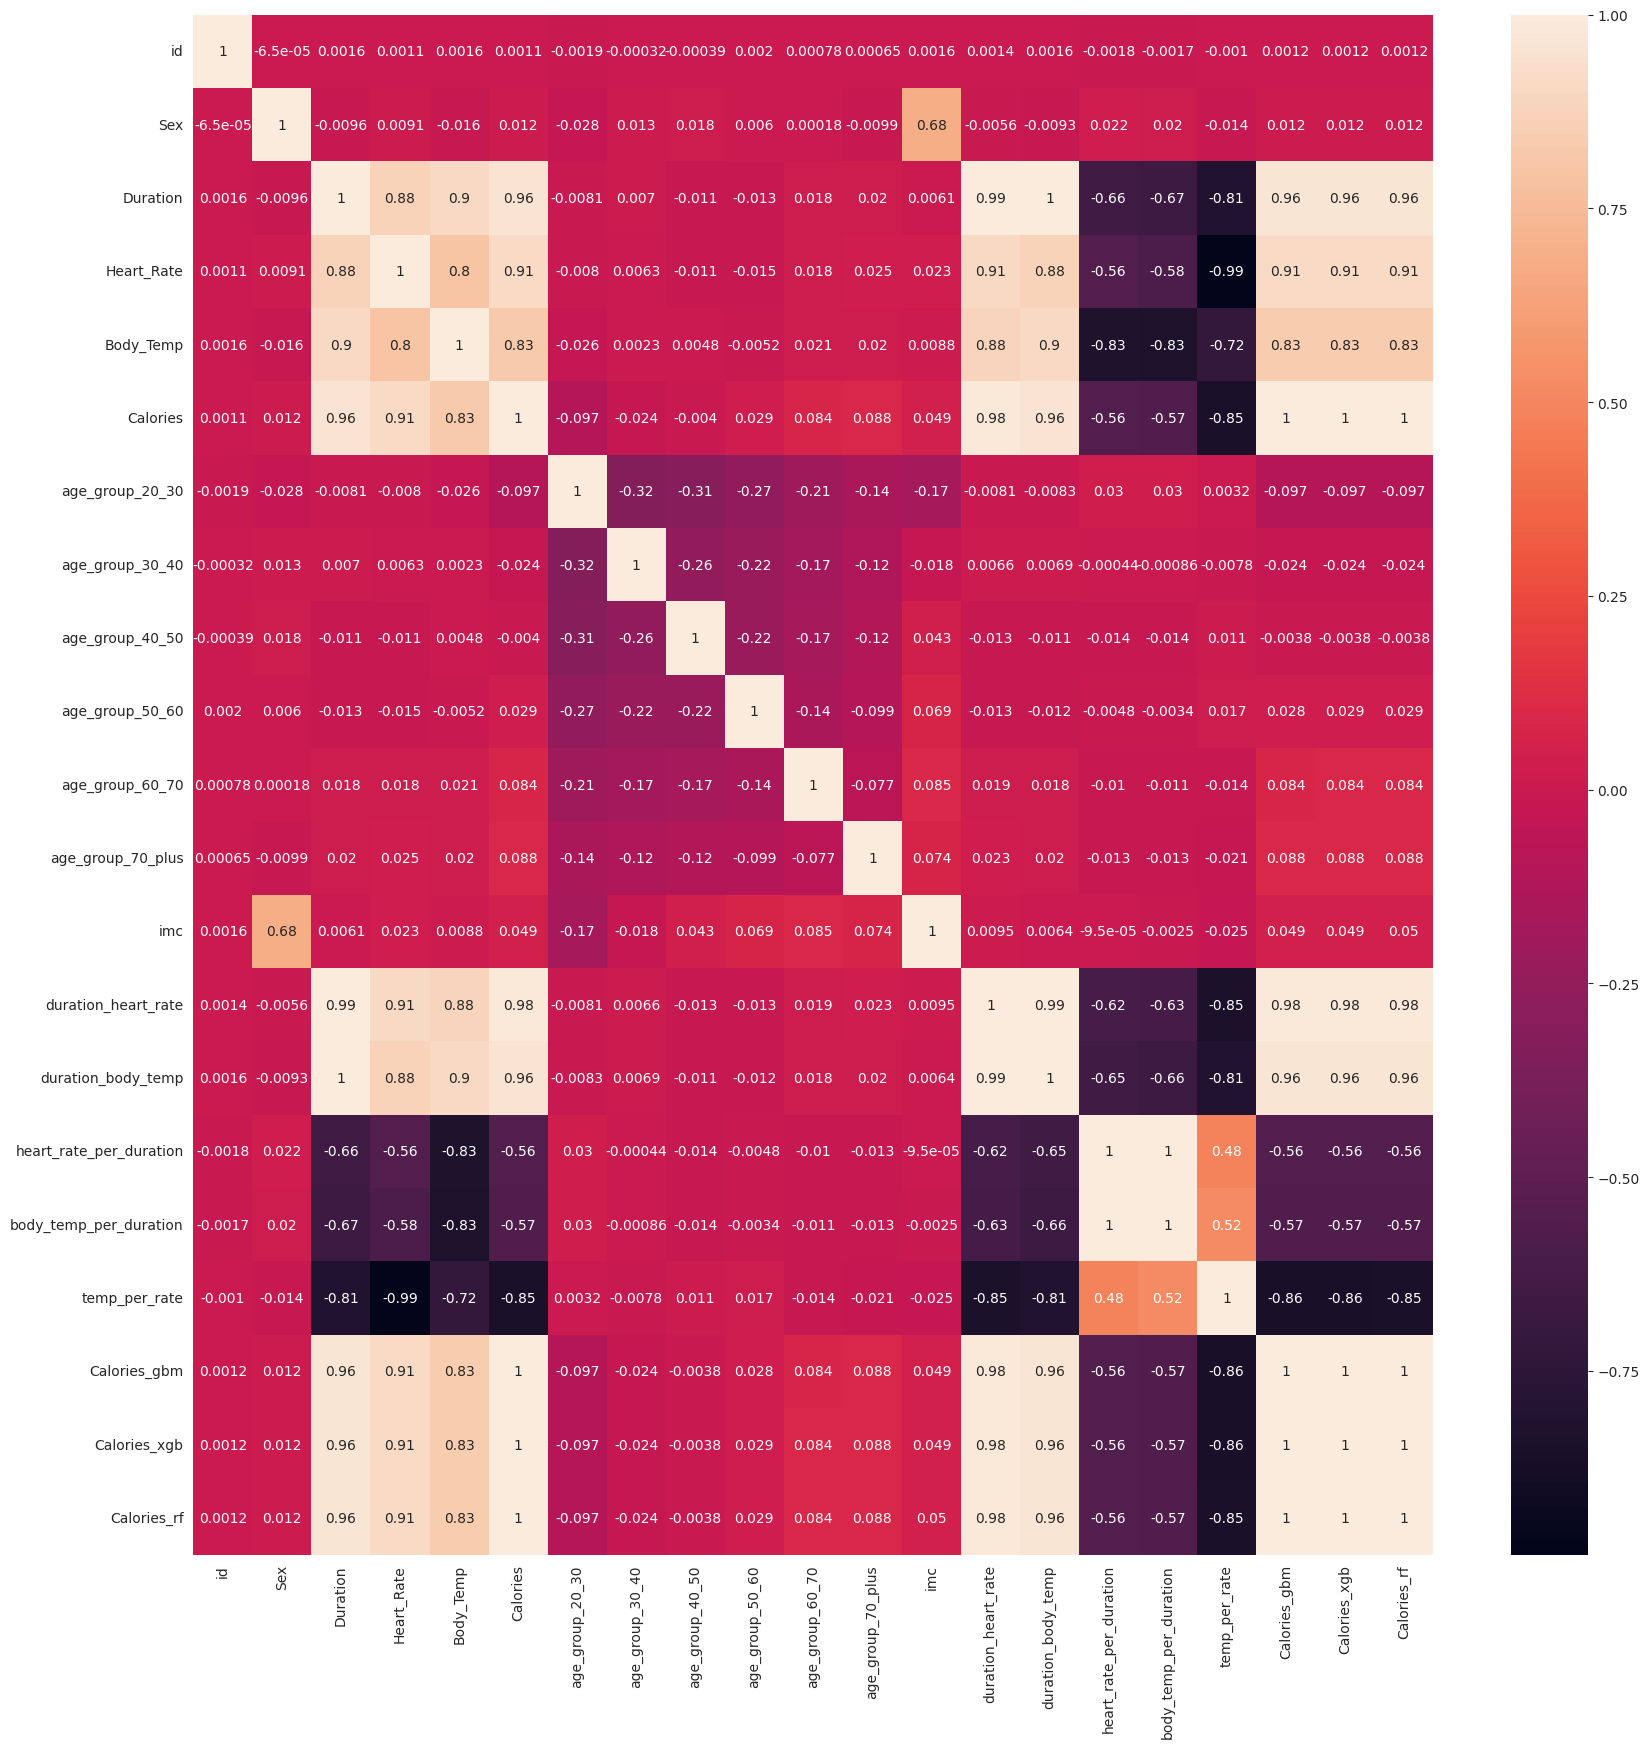

In [40]:
#heatmap de train_df_copy
plt.figure(figsize=(20,20))
sns.heatmap(train_df_copy.corr(), annot=True)

In [41]:
columns_nn = ['Sex', 'Duration', 'age_group_20_30', 'imc', 'duration_heart_rate', 'duration_body_temp', 'heart_rate_per_duration', 'body_temp_per_duration'
              ,'temp_per_rate', 'Calories_gbm', 'Calories_xgb', 'Calories_rf']

In [42]:
X = train_df_copy[columns_nn]
y = train_df_copy['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [43]:
class CaloriePredictionNN(nn.Module):
    def __init__(self, input_size):
        super(CaloriePredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) # Capa lineal con 64 neuronas
        self.relu1 = nn.ReLU()             # Función de activación ReLU
        self.fc2 = nn.Linear(64, 32)        # Otra capa lineal con 32 neuronas
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)         # Capa de salida con 1 neurona (para la predicción de calorías)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Crear una instancia del modelo
input_size = X_train.shape[1] # Número de características de entrada
model = CaloriePredictionNN(input_size)

# Si tienes una GPU disponible, puedes mover el modelo a la GPU
if torch.cuda.is_available():
    model.cuda()

In [44]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr es la tasa de aprendizaje

In [45]:
num_epochs = 100 # Número de veces que el modelo recorrerá el conjunto de entrenamiento

for epoch in range(num_epochs):
    model.train() # Pone el modelo en modo de entrenamiento
    for inputs, targets in train_loader:
        # Mover los datos a la GPU si está disponible
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass y optimización
        optimizer.zero_grad() # Limpia los gradientes anteriores
        loss.backward()       # Calcula los gradientes
        optimizer.step()      # Actualiza los pesos del modelo

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Entrenamiento finalizado.')

Epoch [1/100], Loss: 10.6882
Epoch [2/100], Loss: 24.1000
Epoch [3/100], Loss: 5.0485
Epoch [4/100], Loss: 6.5761
Epoch [5/100], Loss: 9.1985
Epoch [6/100], Loss: 6.5204
Epoch [7/100], Loss: 14.4234
Epoch [8/100], Loss: 16.0473
Epoch [9/100], Loss: 2.1740
Epoch [10/100], Loss: 22.5771
Epoch [11/100], Loss: 12.8370
Epoch [12/100], Loss: 30.6129
Epoch [13/100], Loss: 4.5119
Epoch [14/100], Loss: 3.2998
Epoch [15/100], Loss: 3.5129
Epoch [16/100], Loss: 9.7151
Epoch [17/100], Loss: 6.7114
Epoch [18/100], Loss: 50.7705
Epoch [19/100], Loss: 8.0535
Epoch [20/100], Loss: 7.0111
Epoch [21/100], Loss: 64.2165
Epoch [22/100], Loss: 37.9122
Epoch [23/100], Loss: 79.2907
Epoch [24/100], Loss: 7.9181
Epoch [25/100], Loss: 8.1455
Epoch [26/100], Loss: 14.3935
Epoch [27/100], Loss: 5.4325
Epoch [28/100], Loss: 17.7460
Epoch [29/100], Loss: 24.0944
Epoch [30/100], Loss: 31.8839
Epoch [31/100], Loss: 2.3398
Epoch [32/100], Loss: 7.6384
Epoch [33/100], Loss: 7.3836
Epoch [34/100], Loss: 3.3433
Epoch [3

In [46]:
model.eval() # Pone el modelo en modo de evaluación (desactiva capas como Dropout)
total_loss = 0
with torch.no_grad(): # Desactiva el cálculo de gradientes durante la evaluación
    for inputs, targets in test_loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)

avg_loss = total_loss / len(test_loader.dataset)
print(f'Pérdida en el conjunto de prueba: {avg_loss:.4f}')

Pérdida en el conjunto de prueba: 9.5563


In [47]:
test_final = test_df_copy[columns_nn]
test_final_tensor = torch.tensor(test_final.values, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions_tensor = model(test_final_tensor)
predictions_numpy = predictions_tensor.cpu().numpy()

In [49]:
test_df_copy['Calories'] = predictions_numpy
test_df_copy

,id,Sex,Duration,Heart_Rate,Body_Temp,age_group_20_30,age_group_30_40,age_group_40_50,age_group_50_60,age_group_60_70,...,imc,duration_heart_rate,duration_body_temp,heart_rate_per_duration,body_temp_per_duration,temp_per_rate,Calories_gbm,Calories_xgb,Calories_rf,Calories
0,750000,1,7.0,87.0,39.8,0,0,1,0,0,...,25.854639,609.0,278.6,12.428571,5.685714,0.457471,27.528196,27.051016,26.780000,26.695312
1,750001,1,20.0,101.0,40.5,1,0,0,0,0,...,24.250000,2020.0,810.0,5.050000,2.025000,0.400990,100.214030,102.718781,104.993667,105.571999
2,750002,0,16.0,102.0,40.4,1,0,0,0,0,...,24.049344,1632.0,646.4,6.375000,2.525000,0.396078,87.868590,88.901855,88.860000,89.090874
3,750003,0,20.0,107.0,40.6,0,1,0,0,0,...,24.675500,2140.0,812.0,5.350000,2.030000,0.379439,126.275197,125.517426,126.940000,126.826180
4,750004,0,16.0,94.0,40.5,0,1,0,0,0,...,22.386314,1504.0,648.0,5.875000,2.531250,0.430851,77.287627,79.049538,78.530000,78.873245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,0,6.0,85.0,39.4,0,0,0,1,0,...,24.524346,510.0,236.4,14.166667,6.566667,0.463529,25.880433,25.388876,24.520000,24.429646
249996,999996,1,3.0,84.0,38.4,0,1,0,0,0,...,24.752475,252.0,115.2,28.000000,12.800000,0.457143,8.828302,10.343699,8.580000,8.906498
249997,999997,0,14.0,98.0,40.1,0,1,0,0,0,...,23.795360,1372.0,561.4,7.000000,2.864286,0.409184,73.554398,73.757317,74.900000,74.987274
249998,999998,0,25.0,106.0,40.7,0,0,0,0,1,...,24.435187,2650.0,1017.5,4.240000,1.628000,0.383962,168.995259,166.678894,165.380000,164.899338


In [50]:
sample_submission_df['Calories'] = predictions_numpy
sample_submission_df.to_csv('submissionNN_plus_ml.csv', index=False)